In [1]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import math
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.utils import apply_circular_mask, cartesian_to_polar_grid, polar_transform, polar_transform_inv
from src.model import toeplitz_extractor
from src.visu import add_grad_coloring

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


2024-02-19 13:43:14.438384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:43:14.438464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:43:14.438496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 13:43:14.446232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/project/johannsc/symmetries/RadialBeams/venv/lib/

Num GPUs Available:  1


2024-02-19 13:43:20.466214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43606 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:44:00.0, compute capability: 8.6
2024-02-19 13:43:20.892448: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


2024-02-19 13:43:21.035102: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-19 13:43:21.035562: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-19 13:43:21.036085: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-19 13:43:21.036129: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-19 13:43:21.036306: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-19

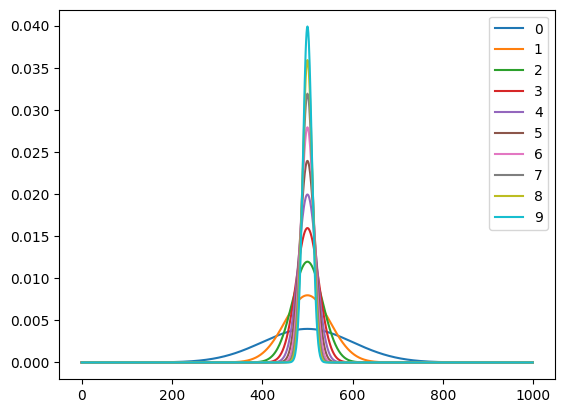

In [2]:
n_beams = 1000
def get_gt_beam_energy(epoch: int):
    sigma = 1/(epoch+1) * 100
    x = tf.range(-(n_beams // 2), n_beams // 2, dtype=tf.float32)
    kernel = 1 / (sigma * tf.math.sqrt(2*math.pi)) * tf.math.exp(-x**2/(2*sigma**2))
    kernel = kernel / tf.reduce_sum(kernel)
    return kernel

fig, ax = plt.subplots()
for e in range(10):
    plt.plot(get_gt_beam_energy(e), label=e)
plt.legend()

In [3]:
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import activations


class GroupConv2D(tf.keras.layers.Layer):
    def __init__(self,
                 input_channels,
                 output_channels,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 dilation_rate=(1, 1),
                 activation=None,
                 groups=1,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(GroupConv2D, self).__init__()

        if not input_channels % groups == 0:
            raise ValueError("The value of input_channels must be divisible by the value of groups.")
        if not output_channels % groups == 0:
            raise ValueError("The value of output_channels must be divisible by the value of groups.")

        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.data_format = data_format
        self.dilation_rate = dilation_rate
        self.activation = activation
        self.groups = groups
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint

        self.group_in_num = input_channels // groups
        self.group_out_num = output_channels // groups
        self.conv_list = []
        for i in range(self.groups):
            self.conv_list.append(tf.keras.layers.Conv2D(filters=self.group_out_num,
                                                         kernel_size=kernel_size,
                                                         strides=strides,
                                                         padding=padding,
                                                         data_format=data_format,
                                                         dilation_rate=dilation_rate,
                                                         activation=activations.get(activation),
                                                         use_bias=use_bias,
                                                         kernel_initializer=initializers.get(kernel_initializer),
                                                         bias_initializer=initializers.get(bias_initializer),
                                                         kernel_regularizer=regularizers.get(kernel_regularizer),
                                                         bias_regularizer=regularizers.get(bias_regularizer),
                                                         activity_regularizer=regularizers.get(activity_regularizer),
                                                         kernel_constraint=constraints.get(kernel_constraint),
                                                         bias_constraint=constraints.get(bias_constraint),
                                                         **kwargs))

    def call(self, inputs, **kwargs):
        feature_map_list = []
        for i in range(self.groups):
            x_i = self.conv_list[i](inputs[:, :, :, i*self.group_in_num: (i + 1) * self.group_in_num])
            feature_map_list.append(x_i)
        out = tf.concat(feature_map_list, axis=-1)
        return out


class ResNeXt_BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filters, strides, groups):
        super(ResNeXt_BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filters,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.group_conv = GroupConv2D(input_channels=filters,
                                      output_channels=filters,
                                      kernel_size=(3, 3),
                                      strides=strides,
                                      padding="same",
                                      groups=groups)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=2 * filters,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.shortcut_conv = tf.keras.layers.Conv2D(filters=2 * filters,
                                                    kernel_size=(1, 1),
                                                    strides=strides,
                                                    padding="same")
        self.shortcut_bn = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=None, **kwargs):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.group_conv(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)

        shortcut = self.shortcut_conv(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        output = tf.nn.relu(tf.keras.layers.add([x, shortcut]))
        return output


def build_ResNeXt_block(filters, strides, groups, repeat_num):
    block = tf.keras.Sequential()
    block.add(ResNeXt_BottleNeck(filters=filters,
                                 strides=strides,
                                 groups=groups))
    for _ in range(1, repeat_num):
        block.add(ResNeXt_BottleNeck(filters=filters,
                                     strides=1,
                                     groups=groups))

    return block


class ResNeXt(tf.keras.Model):
    def __init__(self, repeat_num_list, cardinality, n_classes=1000):
        if len(repeat_num_list) != 4:
            raise ValueError("The length of repeat_num_list must be four.")
        super(ResNeXt, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")
        self.block1 = build_ResNeXt_block(filters=128,
                                          strides=1,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[0])
        self.block2 = build_ResNeXt_block(filters=256,
                                          strides=2,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[1])
        self.block3 = build_ResNeXt_block(filters=512,
                                          strides=2,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[2])
        self.block4 = build_ResNeXt_block(filters=1024,
                                          strides=2,
                                          groups=cardinality,
                                          repeat_num=repeat_num_list[3])
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=n_classes,
                                        activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.block1(x, training=training)
        x = self.block2(x, training=training)
        x = self.block3(x, training=training)
        x = self.block4(x, training=training)

        x = self.pool2(x)
        x = self.fc(x)

        return x


def ResNeXt50():
    return ResNeXt(repeat_num_list=[3, 4, 6, 3],
                   cardinality=32)

model = ResNeXt50()
model.build(input_shape=(4, 224, 224, 3))
model.summary()

Model: "res_ne_xt"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 sequential (Sequential)     (4, 56, 56, 256)          344832    
                                                                 
 sequential_1 (Sequential)   (4, 28, 28, 512)          2004992   
                                                                 
 sequential_2 (Sequential)   (4, 14, 14, 1024)         12

In [4]:
image_size = 224
batch_size = 48
n_epochs = 10
n_channels = 3
n_classes = 1000

# see polar_transform
radius = (np.array([image_size, image_size])**2).sum()**0.5/2
len_beam = int(round(radius))
n_beams = int(round(radius*2*np.pi))
print(len_beam, n_beams)

158 995


NameError: name 'Image' is not defined

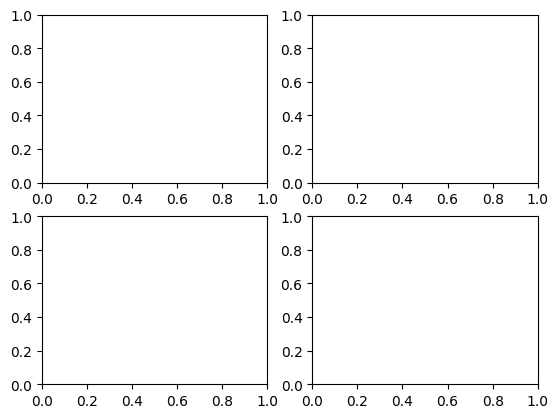

In [5]:
fig, axs = plt.subplots(2,2)

image = Image.open('img/Lenna.png')
image = np.array(image) / 255.
image_size = image.shape[0]
image = apply_circular_mask(image)

downsampled_image = tf.image.resize(image, size=[image_size//8, image_size//8])

axs[0, 0].imshow(image)
axs[1, 0].imshow(downsampled_image)

axs[0, 1].imshow(polar_transform(image))
axs[1, 1].imshow(polar_transform(downsampled_image))

# for ax in axs.ravel():
#     ax.axis("off")

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(3,3)

from PIL import Image
image = Image.open('img/Lenna.png')
image = np.array(image) / 255.
image = apply_circular_mask(image)
  
rot_image = tfa.image.rotate(image, 90., interpolation='bilinear')
rot_image = tf.cast(rot_image, tf.float32)

axs[0, 0].imshow(image)
axs[1, 0].imshow(rot_image)
axs[2, 0].imshow(image)

polar = polar_transform(image)
rot_polar = polar_transform(rot_image)
shifted_polar = tf.roll(polar, shift=50, axis=1)

axs[0, 1].imshow(polar)
axs[1, 1].imshow(rot_polar)
axs[2, 1].imshow(shifted_polar)

polar_inv = polar_transform_inv(polar.numpy(), output=(image_size, image_size))
rot_polar_inv = polar_transform_inv(rot_polar.numpy(), output=(image_size, image_size))
shifted_polar_inv = polar_transform_inv(shifted_polar.numpy(), output=(image_size, image_size))

axs[0, 2].imshow(polar_inv)
axs[1, 2].imshow(rot_polar_inv)
axs[2, 2].imshow(rot_polar_inv)

for ax in axs.ravel():
    ax.axis("off")
    
# plt.show()
plt.savefig('./img/lenna-polar-maps.pdf')